<a href="https://colab.research.google.com/github/Ignacioruuizm/BD_MACHINE_CS_EV4/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Informe Técnico - Examen Transversal: Caso Counter Strike

# Importaciones específicas para SVM

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Cargar los datos
from google.colab import files
uploaded = files.upload()

# Leer el archivo CSV
df = pd.read_csv('Anexo_ET_demo_round_traces_2022_corregido.csv', low_memory=False)

# Eliminar columna de índice innecesaria si existe
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

Saving Anexo_ET_demo_round_traces_2022_corregido.csv to Anexo_ET_demo_round_traces_2022_corregido (4).csv


Preparacion de datos

In [24]:
# Asignar nombres correctos a las columnas
column_names = [
    'PlayerId', 'Map', 'Team', 'InternalTeamId', 'MatchId', 'RoundId', 'RoundWinner',
    'MatchWinner', 'Survived', 'AbnormalMatch', 'TimeAlive', 'TravelledDistance',
    'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle',
    'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'FirstKillTime',
    'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
    'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue', 'MatchKills',
    'MatchFlankKills', 'MatchAssists', 'MatchHeadshots'
]

# Si el dataframe no tiene encabezados, asignamos los nombres
if df.columns[0] == '600':
    df.columns = column_names

# Seleccionar características relevantes
features = [
    'TeamStartingEquipmentValue',
    'RoundStartingEquipmentValue',
    'TimeAlive',
    'TravelledDistance',
    'RoundAssists',
    'RoundHeadshots'
]

# Convertir columnas a numéricas
df[features + ['MatchKills']] = df[features + ['MatchKills']].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
df = df.dropna(subset=features + ['MatchKills'])

# Crear variable objetivo binaria (HighKills = 1 si MatchKills >= 5)
df['HighKills'] = (df['MatchKills'] >= 5).astype(int)

# Balancear las clases
df_majority = df[df['HighKills'] == 0]
df_minority = df[df['HighKills'] == 1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])


/tmp/ipython-input-24-264341978.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HighKills'] = (df['MatchKills'] >= 5).astype(int)


Division, Estandarizacion y Entrenamiento modelo

In [25]:
# División de datos
X = df_balanced[features]
y = df_balanced['HighKills']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento del modelo SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True, random_state=42)

Visualizacion y resultados

### 🔍 Resultados para SVM ###
🔍 Accuracy: 0.7647

📌 Matriz de Confusión:
[[6 3]
 [1 7]]

📄 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.70      0.88      0.78         8

    accuracy                           0.76        17
   macro avg       0.78      0.77      0.76        17
weighted avg       0.78      0.76      0.76        17



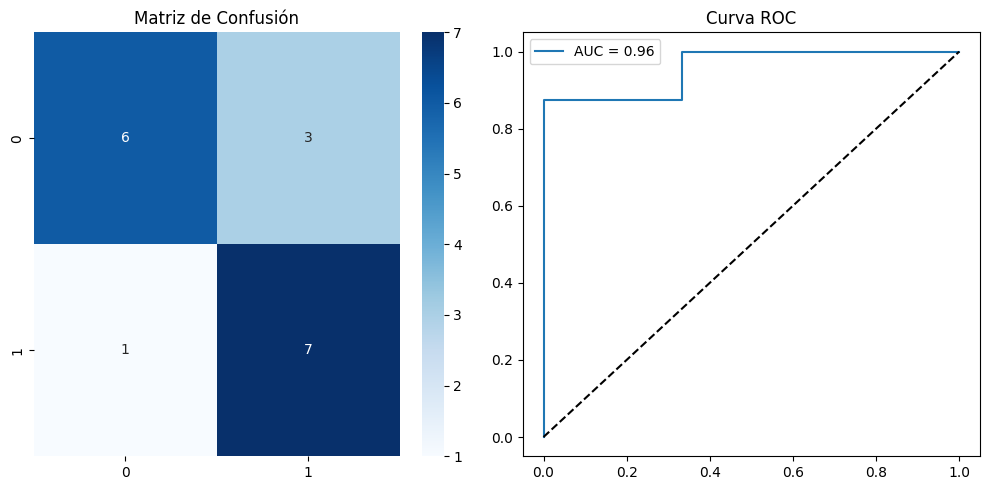

In [26]:
# Evaluación
y_pred = svm_model.predict(X_test_scaled)
y_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# Resultados
print("### 🔍 Resultados para SVM ###")
print(f"🔍 Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

print("📌 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')

plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.legend()
plt.tight_layout()
plt.show()